# Importing a custom Pytorch model into a SageMaker JumpStart private model hub. 


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/NOTEBOOK_PATH)

---

This notebook demostrates how to import custom machine learning model into an Amazon SageMaker JumpStart private model hub. We will start by creating a very simple ANN model with Pytorch. This model built from scratch will be our demo model. We will import it in the the model hub. And finally, we will deploy the model from the private model hub.

The model is a simple ANN model with three fully connected layers. The model takes in 2D input features (X) and predicts a binary classification output (y).The synthetic dataset we're using is generated as follows:
- The input features (X) are randomly generated within the range of [-5, 5] for both dimensions.
- The target labels (y) are assigned based on whether the Euclidean distance of the input feature from the origin (0, 0) is less than 5 or not. If the distance is less than 5, the label is 1, otherwise, it's 0.

The goal of the model is to learn the underlying relationship between the 2D input features and the binary target labels. The model is trained using the Binary Cross-Entropy loss function and the Adam optimizer.


Note: This notebook was tested in Amazon SageMaker Studio on ml.c5.large instance with Python 3 kernel.

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup.

---

In [1]:
# update the sagemaker package version
# restart the kernel after upgrading
!pip install --upgrade sagemaker boto3 botocore

In [2]:
import sagemaker
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import boto3
import os
import json

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## 2. Generate synthetic data for training

In [3]:
# Generate synthetic dataset
num_samples = 1000
X = np.random.rand(num_samples, 2) * 10 - 5  # Input features (2D)
y = np.where(X[:, 0] ** 2 + X[:, 1] ** 2 < 25, 1.0, 0.0)  # Target labels (binary classification)

# Convert dataset to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

## 3. Define the Pytorch ANN model and training

In [4]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [5]:
# Create the model
model = ANN()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor.unsqueeze(1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = (outputs > 0.5).float()
    accuracy = (y_pred == y_tensor.unsqueeze(1)).float().mean()
    print(f"Accuracy: {accuracy.item():.4f}")

Epoch [100/1000], Loss: 0.2945
Epoch [200/1000], Loss: 0.1170
Epoch [300/1000], Loss: 0.0690
Epoch [400/1000], Loss: 0.0479
Epoch [500/1000], Loss: 0.0362
Epoch [600/1000], Loss: 0.0288
Epoch [700/1000], Loss: 0.0237
Epoch [800/1000], Loss: 0.0199
Epoch [900/1000], Loss: 0.0170
Epoch [1000/1000], Loss: 0.0148
Accuracy: 0.9990


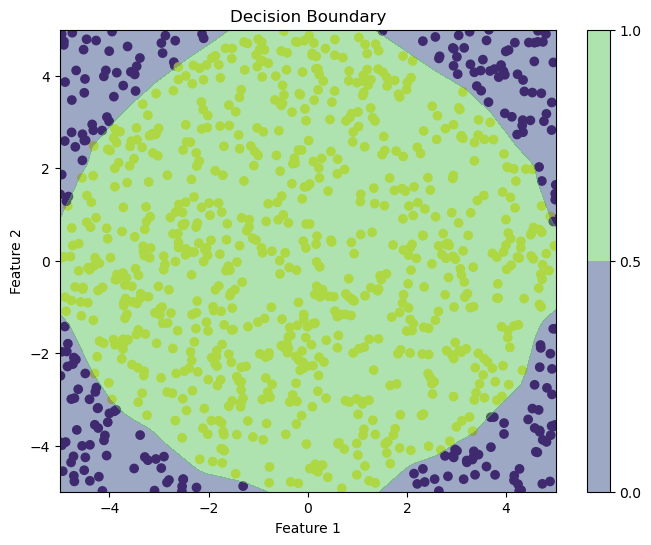

In [6]:
# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)

with torch.no_grad():
    Z = model(torch.tensor(np.column_stack((X1.ravel(), X2.ravel())), dtype=torch.float32))
    Z = Z.reshape(X1.shape)

plt.contourf(X1, X2, Z, levels=[0, 0.5, 1], cmap="viridis", alpha=0.5)
plt.colorbar()
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [7]:
# Save the trained model
torch.save(model.state_dict(), "model.pth")

## 4. Creates a new instance of the model and evaluate 

In [8]:
# creates a new instance of the ANN class
model2 = ANN()

In [9]:
# loads the pre-trained model weights from the file 'model.pth' and assigns them to the model2 instance.
# set the model to evaluation mode. PyTorch, models have two modes: training mode and evaluation mode. Training mode is used during the training process, while evaluation mode is used for making predictions.

model2.load_state_dict(torch.load("model.pth"))
model2.eval()

ANN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
# Prepare the input data for evaluation
X_test = np.random.rand(1, 2) * 10 - 5  # Generate a random test sample
X_tensor = torch.tensor(X_test, dtype=torch.float32)

In [11]:
# Run the model inference
with torch.no_grad():
    output = model2(X_tensor)
    y_pred = (output > 0.5).float().item()

print(f"Input: {X_test}")
print(f"Predicted output: {y_pred}")

Input: [[ 2.46922661 -2.84461124]]
Predicted output: 1.0


# 5. Create the model artifact

In [12]:
!tar -czf model.tar.gz model.pth code/inference.py

# 6. Deploy the model as a SageMaker Endpoint

In [13]:
from sagemaker.pytorch import PyTorchModel

In [14]:
sess = sagemaker.Session()

# Get the default SageMaker bucket
default_bucket = sess.default_bucket()
print(f"The default SageMaker bucket is: {default_bucket}")

s3 = boto3.resource("s3")
sagemaker_runtime = boto3.client("sagemaker-runtime")

key = "demo-model/model.tar.gz"

# Upload the model artifact to Amazon S3
s3.Bucket(default_bucket).upload_file("model.tar.gz", key)

role = sagemaker.get_execution_role()

The default SageMaker bucket is: sagemaker-us-east-1-891376962744


In [15]:
# Deploying an endpoint using the model

model = PyTorchModel(
    model_data=f"s3://{default_bucket}/{key}",
    entry_point="inference.py",
    role=role,
    framework_version="2.3.0",
    py_version="py311",
)

endpoint = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

# Get the endpoint name
endpoint_name = endpoint.endpoint_name

print(f"The deployed endpoint name is: {endpoint_name}")

[02/17/25 14:45:29] INFO     Repacking model artifact                                                  ]8;id=454349;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=966438;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-891376962744/demo-model/model.tar.gz), script               
                             artifact (None), and dependencies ([]) into single tar.gz file located at             
                             s3://sagemaker-us-east-1-891376962744/pytorch-inference-2025-02-17-14-45-             
                             29-731/model.tar.gz. This may take some time depending on model size...               

[02/17/25 14:45:30] INFO     Creating model with name: pytorch-inference-2025-02-17-14-45-30-164    ]8;id=470103;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=820419;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=616689;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=811888;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-inference-2025-02-17-14-45-30-906                                             

[02/17/25 14:45:31] INFO     Creating endpoint with name pytorch-inference-2025-02-17-14-45-30-906  ]8;id=431130;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=387558;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

-----------!The deployed endpoint name is: pytorch-inference-2025-02-17-14-45-30-906


# 7. Performing inference using the SageMaker endpoint

In [16]:
# Define the endpoint name
endpoint_name = endpoint_name


# Define a function to preprocess the input data
def preprocess_input(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    return X_tensor


# Define a function to postprocess the model output
def postprocess_output(output):
    y_pred = (output > 0.5).float()
    return y_pred.item()


# Prepare the input data
X_test = np.random.rand(1, 2) * 10 - 5  # Generate a random test sample

# Preprocess the input data
X_tensor = preprocess_input(X_test)

# Convert the input data to JSON
input_data = {"features": X_tensor.tolist()}
payload = json.dumps(input_data)

# Invoke the SageMaker endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/json", Body=payload
)

# Postprocess the model output
result = json.loads(response["Body"].read().decode())
output = postprocess_output(torch.tensor(result["output"]))

print(f"Input: {X_test}")
print(f"Predicted output: {output}")

Input: [[-1.77928654 -0.53481248]]
Predicted output: 1.0


In [17]:
# delete the endpoint


def del_endpoint(ep):
    try:
        sess.describe_endpoint(ep)
        print(f"Endpoint '{ep}' still exists. Deleting.....")
        sess.delete_endpoint(ep)
    except sagemaker.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "ValidationException":
            print(f"Endpoint '{ep}' has been deleted.")
        else:
            raise e


del_endpoint(endpoint_name)

Endpoint 'pytorch-inference-2025-02-17-14-45-30-906' still exists. Deleting.....


[02/17/25 14:51:33] INFO     Deleting endpoint with name: pytorch-inference-2025-02-17-14-45-30-906 ]8;id=800371;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=118425;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\

# 8. Let's import the custom model into the SageMaker Jumpstart private model hub

In [18]:
from sagemaker import Session

In [19]:
# lets grab some info that we will need from above

model_data = f"s3://{default_bucket}/{key}"


from sagemaker import image_uris

image_uri = image_uris.retrieve(
    framework="pytorch",
    region="us-east-1",
    version="2.3.0",
    py_version="py311",
    image_scope="inference",
    instance_type="ml.c5.xlarge",
)
image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:2.3.0-cpu-py311'

In [20]:
from sagemaker.jumpstart.hub.hub import Hub

default_bucket = sess.default_bucket()
print(default_bucket)

sagemaker-us-east-1-891376962744


In [21]:
# define the private mode hub details to create one.

HUB_NAME = "Custom-Model-HubZ"
HUB_DISPLAY_NAME = "Custom-Model-HubZ"

REGION = "us-east-1"


sm_client = boto3.client("sagemaker")
session = Session(sagemaker_client=sm_client)
session.get_caller_identity_arn()

'arn:aws:iam::891376962744:role/service-role/SageMaker-ExecutionRole-20240626T145306'

In [22]:
hub = Hub(hub_name=HUB_NAME, sagemaker_session=session, bucket_name=default_bucket)

try:
    hub.create(
        description="This is a Curated Hub. Replace this with a description which explains the purpose of this Hub.",
        display_name=HUB_DISPLAY_NAME,
    )
    print(f"Successfully created Hub with name {HUB_NAME} in {REGION}")
except Exception as e:
    if "ResourceInUse" in str(e):
        print(f"A hub with the name {HUB_NAME} already exists in your account.")
    else:
        raise e

A hub with the name Custom-Model-HubZ already exists in your account.


In [23]:
# below is a metadata dict for the models in Jumpstart. this information is used while training or hosting the models by Jumpstart.
# you might need to tweek based on the model that you are importing

hub_model_dict = {
    "Url": "https://anyuniversity.edu",
    "MinSdkVersion": "2.189.0",
    "TrainingSupported": False,
    "IncrementalTrainingSupported": False,
    "HostingArtifactUri": model_data,
    "HostingScriptUri": model_data,
    "HostingUseScriptUri": False,
    "InferenceDependencies": [],
    "InferenceEnvironmentVariables": [
        {
            "Name": "SAGEMAKER_PROGRAM",
            "Type": "text",
            "Default": "inference.py",
            "Scope": "container",
            "RequiredForModelClass": True,
        },
        {
            "Name": "SAGEMAKER_SUBMIT_DIRECTORY",
            "Type": "text",
            "Default": model_data,
            "Scope": "container",
            "RequiredForModelClass": False,
        },
        {
            "Name": "TS_MAX_RESPONSE_SIZE",
            "Type": "text",
            "Default": "100000000",
            "Scope": "container",
            "RequiredForModelClass": True,
        },
        {
            "Name": "TS_MAX_REQUEST_SIZE",
            "Type": "text",
            "Default": "100000000",
            "Scope": "container",
            "RequiredForModelClass": True,
        },
    ],
    "DefaultInferenceInstanceType": "ml.c5.4xlarge",
    "SupportedInferenceInstanceTypes": ["ml.c5.4xlarge", "ml.c5.9xlarge", "ml.g4dn.2xlarge"],
    "InferenceEnableNetworkIsolation": False,
    "ValidationSupported": False,
    "ResourceNameBase": "Custom-Model-Hub1",
    "HostingInstanceTypeVariants": {
        "Variants": {
            "c5": {"Properties": {"ImageUri": image_uri}},
            "ml.c5.4xlarge": {"Properties": {"ResourceRequirements": {"MinMemoryMb": 16384}}},
            "ml.c5.9xlarge": {"Properties": {"ResourceRequirements": {"MinMemoryMb": 32768}}},
        }
    },
    "HostingArtifactS3DataType": "S3Prefix",
    "HostingArtifactCompressionType": "Gzip",
    "HostingResourceRequirements": {"MinMemoryMb": 16384},
    "DynamicContainerDeploymentSupported": True,
    "Dependencies": [],
    "HostingEcrUri": image_uri,
    "Task": "blog model",
    "Framework": "custom",
    "SageMakerSdkPredictorSpecifications": {
        "SupportedContentTypes": ["application/x-image"],
        "SupportedAcceptTypes": [
            "application/json",
            "application/json;verbose",
            "application/json;n_predictions=2",
        ],
        "DefaultContentType": "application/x-image",
        "DefaultAcceptType": "application/json",
    },
}

# Convert the dictionary to a JSON string
hub_doc = json.dumps(hub_model_dict)

# If you need to parse it back into a dictionary (which you shouldn't need to do in this case)
# hub_model_dict = json.loads(hub_doc)

print(hub_doc)

{"Url": "https://anyuniversity.edu", "MinSdkVersion": "2.189.0", "TrainingSupported": false, "IncrementalTrainingSupported": false, "HostingArtifactUri": "s3://sagemaker-us-east-1-891376962744/demo-model/model.tar.gz", "HostingScriptUri": "s3://sagemaker-us-east-1-891376962744/demo-model/model.tar.gz", "HostingUseScriptUri": false, "InferenceDependencies": [], "InferenceEnvironmentVariables": [{"Name": "SAGEMAKER_PROGRAM", "Type": "text", "Default": "inference.py", "Scope": "container", "RequiredForModelClass": true}, {"Name": "SAGEMAKER_SUBMIT_DIRECTORY", "Type": "text", "Default": "s3://sagemaker-us-east-1-891376962744/demo-model/model.tar.gz", "Scope": "container", "RequiredForModelClass": false}, {"Name": "TS_MAX_RESPONSE_SIZE", "Type": "text", "Default": "100000000", "Scope": "container", "RequiredForModelClass": true}, {"Name": "TS_MAX_REQUEST_SIZE", "Type": "text", "Default": "100000000", "Scope": "container", "RequiredForModelClass": true}], "DefaultInferenceInstanceType": "ml.

In [24]:
# importing to the hub

sm_client.import_hub_content(
    HubContentName="blog-model-test0213",
    HubContentType="Model",
    DocumentSchemaVersion="2.2.0",
    HubName=HUB_NAME,
    HubContentDocument=hub_doc,
)

{'HubArn': 'arn:aws:sagemaker:us-east-1:891376962744:hub/Custom-Model-HubZ',
 'HubContentArn': 'arn:aws:sagemaker:us-east-1:891376962744:hub-content/Custom-Model-HubZ/Model/blog-model-test0213/0.0.5',
 'ResponseMetadata': {'RequestId': '7e556141-cdfe-4450-887f-00a6622fe915',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7e556141-cdfe-4450-887f-00a6622fe915',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '196',
   'date': 'Mon, 17 Feb 2025 14:51:33 GMT'},
  'RetryAttempts': 0}}

In [25]:
# list the models from the private hub
hub.list_models()

{'hub_content_summaries': [{'HubContentName': 'blog-model-test0213',
   'HubContentArn': 'arn:aws:sagemaker:us-east-1:891376962744:hub-content/Custom-Model-HubZ/Model/blog-model-test0213/0.0.5',
   'HubContentVersion': '0.0.5',
   'HubContentType': 'Model',
   'DocumentSchemaVersion': '2.2.0',
   'HubContentStatus': 'Available',
   'CreationTime': datetime.datetime(2025, 2, 17, 14, 51, 33, 773000, tzinfo=tzlocal())}],
 'next_token': None}

In [26]:
# retrieve the HUB's arn
HUB_ARN = hub.describe()["HubArn"]
print(HUB_ARN)

# get the model id
model_id = hub.list_models()["hub_content_summaries"][0]["HubContentName"]
print(model_id)

# get the model version
version = hub.list_models()["hub_content_summaries"][0]["HubContentVersion"]
print(version)

arn:aws:sagemaker:us-east-1:891376962744:hub/Custom-Model-HubZ
blog-model-test0213
0.0.5


# 9. Deploy the model from private model hub as a real time inference endpoint

In [27]:
# deploy the model from the hub as an endpoint
from sagemaker.jumpstart.model import JumpStartModel

model = JumpStartModel(model_id=model_id, model_version=version, hub_name=HUB_ARN, region=REGION)
predictor = model.deploy(accept_eula=True, initial_instance_count=1, instance_type="ml.c5.4xlarge")

endpoint_name = predictor.endpoint_name
endpoint_name

[02/17/25 14:51:34] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=878973;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=559933;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=223690;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=909365;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=105393;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=796986;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

[02/17/25 14:51:35] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=816882;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=567035;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=527197;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=107439;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=193636;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=640874;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

No instance type selected for inference hosting endpoint. Defaulting to ml.c5.4xlarge.


                    INFO     No instance type selected for inference hosting endpoint. Defaulting to   ]8;id=323417;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/factory/model.py\model.py]8;;\:]8;id=605664;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/factory/model.py#238\238]8;;\
                             ml.c5.4xlarge.                                                                        

[02/17/25 14:51:36] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=782491;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=518388;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=118265;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=537065;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=14604;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=959508;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=358785;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=974189;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=706385;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=466958;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=323767;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=327275;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=189155;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=573589;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

[02/17/25 14:51:41] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=752766;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=388543;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=848202;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=896169;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

[02/17/25 14:51:42] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=65424;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=697727;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=929068;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=706842;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=860324;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=646552;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=465766;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=803436;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Creating model with name: Custom-Model-Hub1-2025-02-17-14-51-35-834    ]8;id=10856;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=558405;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/17/25 14:51:43] INFO     Creating endpoint-config with name                                     ]8;id=566031;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=761732;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             Custom-Model-Hub1-2025-02-17-14-51-42-318                                             

                    INFO     Creating endpoint with name Custom-Model-Hub1-2025-02-17-14-51-42-318  ]8;id=921638;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=600619;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

[02/17/25 14:55:14] INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=6083;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=720138;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=148527;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=697036;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=614792;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=648039;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

                    INFO     Received exeption while calling APIs for ContentType ModelReference,  ]8;id=607221;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py\accessors.py]8;;\:]8;id=462711;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/accessors.py#303\303]8;;\
                             retrying with ContentType Model: Failed calling                                       
                             list_hub_content_versions: An error occurred (ResourceNotFound) when                  
                             calling the ListHubContentVersions operation: Hub content with name                   
                             blog-model-test0213 does not exist.                                                   

'Custom-Model-Hub1-2025-02-17-14-51-42-318'

# 10. Lets invoke the newly deployed endpoint

In [28]:
# Prepare the input data
X_test = np.random.rand(1, 2) * 10 - 5  # Generate a random test sample

# Preprocess the input data
X_tensor = preprocess_input(X_test)

# Convert the input data to JSON
input_data = {"features": X_tensor.tolist()}
payload = json.dumps(input_data)

# Invoke the SageMaker endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/json", Body=payload
)

# Postprocess the model output
result = json.loads(response["Body"].read().decode())
output = postprocess_output(torch.tensor(result["output"]))

print(f"Input: {X_test}")
print(f"Predicted output: {output}")

Input: [[-0.08725895  0.26641974]]
Predicted output: 1.0


# 11. Clean up

In [29]:
del_endpoint(endpoint_name)

Endpoint 'Custom-Model-Hub1-2025-02-17-14-51-42-318' still exists. Deleting.....


[02/17/25 14:55:15] INFO     Deleting endpoint with name: Custom-Model-Hub1-2025-02-17-14-51-42-318 ]8;id=624158;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=535692;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/NOTEBOOK_PATH)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/NOTEBOOK_PATH)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/NOTEBOOK_PATH)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/NOTEBOOK_PATH)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/NOTEBOOK_PATH)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/NOTEBOOK_PATH)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/NOTEBOOK_PATH)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/NOTEBOOK_PATH)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/NOTEBOOK_PATH)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/NOTEBOOK_PATH)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/NOTEBOOK_PATH)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/NOTEBOOK_PATH)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/NOTEBOOK_PATH)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/NOTEBOOK_PATH)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/NOTEBOOK_PATH)
